<a href="https://colab.research.google.com/github/boteny02/Prediction-of-prostate/blob/main/MM_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task
Implement a medical image classification pipeline using the "MRI_Metadata.xlsx" file and corresponding MRI images. The pipeline will involve feature extraction with a pre-trained ResNet model, feature selection using the ReliefF algorithm, training a suitable classifier, and evaluating its performance.

## Load and Preprocess Metadata

### Subtask:
Load the /content/drive/MyDrive/PhD_dataset/file_details_with_labels.xlsx file using pandas to inspect its structure and content. Perform any necessary initial data cleaning, handle missing values, and prepare the metadata for linking with image files.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:


# Load the MRI_Metadata.xlsx file into a pandas DataFrame
df_metadata = pd.read_excel('/content/drive/MyDrive/PhD_dataset/file_details_with_labels.xlsx')

# Display the first five rows of the DataFrame
print('First 5 rows of the DataFrame:')
print(df_metadata.head())
print('\n')


First 5 rows of the DataFrame:
   Patient  Exam  Series  ExamDescription  \
0        1     1       1  PROSTATE BIOPSY   
1        1     1       1  PROSTATE BIOPSY   
2        1     1       1  PROSTATE BIOPSY   
3        1     1       1  PROSTATE BIOPSY   
4        1     1       1  PROSTATE BIOPSY   

                                           File_Path  Filename  Label  
0  /content/drive/MyDrive/PhD_dataset/000001_0000...  0001.png      0  
1  /content/drive/MyDrive/PhD_dataset/000001_0000...  0002.png      0  
2  /content/drive/MyDrive/PhD_dataset/000001_0000...  0003.png      0  
3  /content/drive/MyDrive/PhD_dataset/000001_0000...  0004.png      0  
4  /content/drive/MyDrive/PhD_dataset/000001_0000...  0005.png      0  




In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/PhD_dataset/prostate_cancer_prediction.csv')

# Display the first 5 rows
print("First 5 rows of the DataFrame:")
df.head()

First 5 rows of the DataFrame:


,Patient_ID,Age,Family_History,Race_African_Ancestry,PSA_Level,DRE_Result,Biopsy_Result,Difficulty_Urinating,Weak_Urine_Flow,Blood_in_Urine,...,Alcohol_Consumption,Hypertension,Diabetes,Cholesterol_Level,Screening_Age,Follow_Up_Required,Prostate_Volume,Genetic_Risk_Factors,Previous_Cancer_History,Early_Detection
0,1,78,No,Yes,5.07,Normal,Benign,No,No,No,...,Moderate,No,No,Normal,45,No,46.0,No,No,Yes
1,2,68,No,Yes,10.24,Normal,Benign,Yes,No,No,...,Low,No,No,High,65,No,78.2,No,No,Yes
2,3,54,No,No,13.79,Normal,Benign,No,No,No,...,Low,No,No,Normal,61,No,21.1,No,No,Yes
3,4,82,No,No,8.03,Abnormal,Benign,No,No,No,...,Low,No,No,Normal,47,Yes,79.9,No,Yes,Yes
4,5,47,Yes,No,1.89,Normal,Malignant,Yes,Yes,No,...,Moderate,Yes,No,Normal,72,No,32.0,No,No,Yes


In [ ]:
df_metadata.head(2)

,Patient,Exam,Series,ExamDescription,File_Path,Filename,Label,File_Exists
0,1,1,1,PROSTATE BIOPSY,/content/drive/MyDrive/PhD_dataset/000001_0000...,0001.png,0,True
1,1,1,1,PROSTATE BIOPSY,/content/drive/MyDrive/PhD_dataset/000001_0000...,0002.png,0,True


In [ ]:
df_metadata.value_counts('Label')

,count
Label,
0,4383
1,1459


# Task
Implement a medical image classification pipeline using the metadata from `/content/drive/MyDrive/PhD_dataset/file_details_with_labels.xlsx` and the corresponding MRI images. This pipeline should include loading and preprocessing the metadata, preparing image data paths, downloading and extracting image data, defining and loading a pre-trained ResNet model for feature extraction, extracting features from the MRI images, applying ReliefF for feature selection, training a suitable classifier, and evaluating the model's performance with appropriate metrics for medical image classification. Finally, summarize the entire pipeline and results in a note cell.

## Load and Preprocess Metadata

### Subtask:
Perform initial data cleaning and prepare metadata for linking with image files.


**Reasoning**:
The subtask requires checking for and handling duplicate rows, analyzing the distribution of the 'Label' column, and examining unique values in the 'ExamDescription' column. These steps will be performed sequentially in a single code block.

**Reasoning**:
The 'ExamDescription' column contains several similar but not identical values (e.g., 'PROSTATE', 'PROSTATE ', 'PROSTATE BIOPSY', 'PROSTATE BX'). Standardizing these values will improve data consistency and facilitate easier analysis and filtering. This step is part of the initial data cleaning process to prepare the metadata.




In [ ]:
print('Checking for duplicate rows...')
duplicate_rows = df_metadata.duplicated().sum()

if duplicate_rows > 0:
    print(f'Found {duplicate_rows} duplicate rows. Dropping duplicates...')
    df_metadata.drop_duplicates(inplace=True)
    print(f'New DataFrame shape after dropping duplicates: {df_metadata.shape}')
else:
    print('No duplicate rows found.')

# Clean up whitespace and convert to uppercase for consistency
df_metadata['ExamDescription'] = df_metadata['ExamDescription'].str.strip().str.upper()

# Standardize similar descriptions
df_metadata['ExamDescription'] = df_metadata['ExamDescription'].replace({
    'PROSTATE BX': 'PROSTATE BIOPSY',
    'PROSTATE -NO COIL': 'PROSTATE',
    'PROSTATE  W/ SPEC': 'PROSTATE'
})

print('\nAnalyzing the distribution of the Label column:')
print(df_metadata['Label'].value_counts())

print('\nExamining unique values in the ExamDescription column:')
print(df_metadata['ExamDescription'].unique())

print('\nValue counts for ExamDescription after standardization:')
print(df_metadata['ExamDescription'].value_counts())

Checking for duplicate rows...
No duplicate rows found.

Analyzing the distribution of the Label column:
Label
0    4383
1    1459
Name: count, dtype: int64

Examining unique values in the ExamDescription column:
['PROSTATE BIOPSY' 'PROSTATE' 'BRACHYTHERAPY' 'PROSTATE STAGING'
 'DIED OF DISEASE PROSTATE']

Value counts for ExamDescription after standardization:
ExamDescription
PROSTATE                    4163
BRACHYTHERAPY                715
PROSTATE BIOPSY              571
DIED OF DISEASE PROSTATE     224
PROSTATE STAGING             169
Name: count, dtype: int64


# Task
## Prepare Image Data Paths

### Subtask:
Verify the existence and accessibility of the image paths specified in the 'File_Path' column of the `df_metadata` DataFrame. This involves checking if each file path points to an actual file on the system.

### Reasoning:
Before proceeding with image loading and feature extraction, it's crucial to confirm that all referenced image files are accessible. This step identifies any broken paths or missing files early in the pipeline, preventing errors in subsequent stages and ensuring that only valid image data is processed. We will iterate through the `File_Path` column, check each path, and report on the overall accessibility. If any file paths are invalid, they should be identified and handled, potentially by removing the corresponding entries from the metadata or flagging them for further investigation.

## Prepare Image Data Paths

### Subtask:
Verify the existence and accessibility of the image paths specified in the 'File_Path' column of the `df_metadata` DataFrame.


**Reasoning**:
The subtask requires verifying the existence and accessibility of image paths. This involves importing the `os` module, defining a function to check file existence, applying this function to the 'File_Path' column to create a new 'File_Exists' column, summarizing the results, and then filtering the DataFrame to retain only valid paths.



In [ ]:
import os

# Define a function to check if a file exists
def check_file_exists(file_path):
    return os.path.exists(file_path)

print("Verifying file paths...")
# Apply the function to the 'File_Path' column to create 'File_Exists'
df_metadata['File_Exists'] = df_metadata['File_Path'].apply(check_file_exists)

# Count and print the number of True and False values in 'File_Exists'
print('\nFile existence check summary:')
print(df_metadata['File_Exists'].value_counts())

# Create a new DataFrame with only valid paths
df_metadata_valid_paths = df_metadata[df_metadata['File_Exists'] == True].copy()

print(f'\nOriginal DataFrame shape: {df_metadata.shape}')
print(f'DataFrame with valid paths shape: {df_metadata_valid_paths.shape}')

print('\nFirst 5 rows of df_metadata_valid_paths:')
print(df_metadata_valid_paths.head())

Verifying file paths...

File existence check summary:
File_Exists
True    5842
Name: count, dtype: int64

Original DataFrame shape: (5842, 8)
DataFrame with valid paths shape: (5842, 8)

First 5 rows of df_metadata_valid_paths:
   Patient  Exam  Series  ExamDescription  \
0        1     1       1  PROSTATE BIOPSY   
1        1     1       1  PROSTATE BIOPSY   
2        1     1       1  PROSTATE BIOPSY   
3        1     1       1  PROSTATE BIOPSY   
4        1     1       1  PROSTATE BIOPSY   

                                           File_Path  Filename  Label  \
0  /content/drive/MyDrive/PhD_dataset/000001_0000...  0001.png      0   
1  /content/drive/MyDrive/PhD_dataset/000001_0000...  0002.png      0   
2  /content/drive/MyDrive/PhD_dataset/000001_0000...  0003.png      0   
3  /content/drive/MyDrive/PhD_dataset/000001_0000...  0004.png      0   
4  /content/drive/MyDrive/PhD_dataset/000001_0000...  0005.png      0   

   File_Exists  
0         True  
1         True  
2         

## Apply StandardScaler

### Subtask:
Initialize the `StandardScaler` and apply it to the identified numerical columns in both `x_train` and `x_test`. The scaler should be fitted only on `x_train` to prevent data leakage.


**Reasoning**:
To scale the numerical features, I will import `StandardScaler`, instantiate it, fit it on the training numerical data (`x_train_numerical`), and then transform both the training and testing numerical data (`x_train_numerical` and `x_test_numerical`) to `x_train_scaled` and `x_test_scaled` respectively, ensuring no data leakage.



## Define and Load CNN Model for Feature Extraction (ResNet)

### Subtask:
Load a pre-trained ResNet model, specifically ResNet50, and modify it by removing its final classification layers to use it as a feature extractor.


**Reasoning**:
I need to import the necessary Keras modules, load the pre-trained ResNet50 model without its top classification layer, and then define a new model that applies global average pooling to the ResNet50's output to serve as a feature extractor. This will be done in a single code block as per the instructions.



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

print("Loading pre-trained ResNet50 model...")
# 1. Load the pre-trained ResNet50 model
#    include_top=False removes the final classification layers
#    weights='imagenet' loads the weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Create a new model for feature extraction
#    Take the output of the base model and apply GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Define the feature extraction model
feature_extractor = Model(inputs=base_model.input, outputs=x)

print("ResNet50 feature extractor loaded and configured.")
print("Summary of the feature extractor model:")
feature_extractor.summary()

Loading pre-trained ResNet50 model...
ResNet50 feature extractor loaded and configured.
Summary of the feature extractor model:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Extract Features from MRI Images

### Subtask:
Process the MRI images to extract features using the pre-trained and modified ResNet50 model (`feature_extractor`). This involves loading each image, preprocessing it to match the input requirements of ResNet50, and then using the model to obtain feature vectors.

#### Instructions
1.  Define a function to load and preprocess a single image file. This function should:
    *   Load the image using `tf.keras.preprocessing.image.load_img`.
    *   Resize the image to (224, 224) as required by ResNet50.
    *   Convert the image to a NumPy array.
    *   Expand dimensions to create a batch dimension (e.g., from (224, 224, 3) to (1, 224, 224, 3)).
    *   Preprocess the image using `tf.keras.applications.resnet50.preprocess_input`.
2.  Iterate through the `File_Path` column of `df_metadata_valid_paths`.
3.  For each image path, load and preprocess the image using the function defined in step 1.
4.  Use the `feature_extractor.predict()` method to extract features for each preprocessed image.
5.  Store the extracted features in a list or a NumPy array.
6.  Ensure that the extracted features are reshaped if necessary to be 2D (number of samples, number of features).

**Reasoning**:
The previous markdown block detailed the instructions for extracting features from the MRI images using the pre-trained ResNet50 model. This code block will implement those instructions by defining an image preprocessing function, iterating through the image paths in the DataFrame, extracting features for each image, and storing them in a NumPy array.



In [ ]:
import numpy as np
from tqdm.notebook import tqdm

# Define a function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

print("Extracting features from MRI images...")

# List to store extracted features
extracted_features = []

# Iterate through the DataFrame and extract features for each image
for index, row in tqdm(df_metadata_valid_paths.iterrows(), total=len(df_metadata_valid_paths)):
    image_path = row['File_Path']
    preprocessed_img = load_and_preprocess_image(image_path)

    if preprocessed_img is not None:
        features = feature_extractor.predict(preprocessed_img, verbose=0) # Use verbose=0 to suppress output for each prediction
        extracted_features.append(features.flatten()) # Flatten the features to a 1D array

# Convert the list of features to a NumPy array
features_array = np.array(extracted_features)

print(f"Finished feature extraction. Total features extracted: {len(extracted_features)}")
print(f"Shape of the extracted features array: {features_array.shape}")

# Optionally, add features to the DataFrame
df_metadata_valid_paths['Features'] = list(extracted_features)
print("Features successfully extracted and stored in 'features_array' and 'df_metadata_valid_paths'.")

Extracting features from MRI images...


  0%|          | 0/5842 [00:00<?, ?it/s]

Finished feature extraction. Total features extracted: 5842
Shape of the extracted features array: (5842, 2048)
Features successfully extracted and stored in 'features_array' and 'df_metadata_valid_paths'.


# Task
## Apply ReliefF Feature Selection

### Subtask:
Utilize the ReliefF algorithm to select the most relevant features from the `features_array`. This involves importing a ReliefF implementation, fitting it to the feature data and labels, and obtaining feature importances to select a subset of discriminative features for downstream classification.

### Reasoning:
ReliefF is a feature selection algorithm that assigns weights to features based on their ability to distinguish between neighboring instances from different classes. This helps in identifying features that are more discriminative for the classification task, potentially improving model performance and reducing dimensionality. The `skrebate` library provides a suitable implementation for ReliefF. We will fit ReliefF to the extracted features and the corresponding labels, then use the calculated feature importances to select a subset of the most relevant features. This step is crucial for preparing the data for the classifier training.

**Reasoning**:
To proceed with ReliefF feature selection, I first need to install the `scikit-rebate` library, which contains the algorithm. After installation, I will extract the target labels and then apply the ReliefF algorithm as instructed.



In [ ]:
print("Installing skrebate...")
!pip install skrebate

import numpy as np
from skrebate import ReliefF

# Prepare data for ReliefF
X = features_array  # Our extracted features
y = df_metadata_valid_paths['Label'].values  # Target labels

print(f"Shape of features (X): {X.shape}")
print(f"Shape of labels (y): {y.shape}")

# Instantiate ReliefF model
# n_neighbors: The number of nearest neighbors to consider
print("Instantiating and fitting ReliefF model...")
# Removed n_features_to_keep and random_state from constructor as they are not valid arguments
relief = ReliefF(n_neighbors=10)

# Fit ReliefF to the data
relief.fit(X, y)

# Get all feature indices sorted by importance, then select the top N
desired_n_features = 200
sorted_feature_indices = relief.top_features_
selected_feature_indices = sorted_feature_indices[:desired_n_features]

# Create a new feature set with only the selected features
selected_features = X[:, selected_feature_indices]

print(f"Original number of features: {X.shape[1]}")
print(f"Number of features selected by ReliefF: {selected_features.shape[1]}")
print(f"Shape of selected features array: {selected_features.shape}")

print("ReliefF feature selection completed.")

Installing skrebate...
  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=604fdecee58a72916a3864f751985a9d739cd289f2d8bb980332ed527ea8dc43
  Stored in directory: /root/.cache/pip/wheels/03/4c/36/bc6b70d88998635e0ec0e617d15cd97483f5008d6bb77c1c7a
Successfully built skrebate
Shape of features (X): (5842, 2048)
Shape of labels (y): (5842,)
Instantiating and fitting ReliefF model...
Original number of features: 2048
Number of features selected by ReliefF: 200
Shape of selected features array: (5842, 200)
ReliefF feature selection completed.


## Train Classifier

### Subtask:
Using the features selected by the ReliefF algorithm, split the dataset into training and testing sets. Then, train a suitable machine learning classifier for medical image classification.


**Reasoning**:
To prepare for model training and evaluation, I need to split the data into training and testing sets and then train a RandomForestClassifier as instructed.



In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(selected_features, y, test_size=0.2, random_state=42)



print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


# Assume the dataset has a 'MRI' column and a 'cancer' column (1 for cancer, 0 for no cancer)
# Adjust column names based on your actual dataset

# Initialize individual models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(probability=True, random_state=42) # probability=True for VotingClassifier with soft voting
knn_model = KNeighborsClassifier()
lr_model = LogisticRegression(random_state=42)
nb_model = GaussianNB()

# Build the ANN model
ann_model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train individual models
print("Training individual models...")
dt_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train_scaled, y_train)
svm_model.fit(X_train_scaled, y_train)
knn_model.fit(X_train_scaled, y_train)
lr_model.fit(X_train_scaled, y_train)
nb_model.fit(X_train_scaled, y_train)
ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0) # Train ANN

In [ ]:
# Ensure skrebate is installed for ReliefF feature selection
!pip install skrebate

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os
import numpy as np
from skrebate import ReliefF

# Original imports for this cell
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# --- Code from Cell 38f151e2: Define and Load CNN Model for Feature Extraction (ResNet) ---
print("Loading pre-trained ResNet50 model for feature extraction...")
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)
print("ResNet50 feature extractor configured.")

# --- Code from Cell f5d3f8b5: Prepare Image Data Paths ---
# df_metadata is assumed to be available from previously executed cells (e.g., 89356212, bf1e5bbb)
print("Verifying file paths...")
def check_file_exists(file_path):
    return os.path.exists(file_path)
df_metadata['File_Exists'] = df_metadata['File_Path'].apply(check_file_exists)
df_metadata_valid_paths = df_metadata[df_metadata['File_Exists'] == True].copy()
print(f"DataFrame with valid paths shape: {df_metadata_valid_paths.shape}")

# --- Code from Cell 9c4a5dcd: Extract Features from MRI Images ---
print("Extracting features from MRI images...")
def load_and_preprocess_image(image_path):
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        return img_array
    except Exception as e:
        # print(f"Error processing image {image_path}: {e}") # Suppress detailed error for combined cell
        return None

extracted_features = []
# Using iterrows without tqdm for simplicity in combined cell
for index, row in df_metadata_valid_paths.iterrows():
    image_path = row['File_Path']
    preprocessed_img = load_and_preprocess_image(image_path)
    if preprocessed_img is not None:
        features = feature_extractor.predict(preprocessed_img, verbose=0)
        extracted_features.append(features.flatten())
features_array = np.array(extracted_features)
print(f"Finished feature extraction. Total features extracted: {len(extracted_features)}")
print(f"Shape of the extracted features array: {features_array.shape}")

# --- Code from Cell 7a543810: Apply ReliefF Feature Selection ---
print("Instantiating and fitting ReliefF model...")
X_relief = features_array
y = df_metadata_valid_paths['Label'].values

relief = ReliefF(n_neighbors=10)
relief.fit(X_relief, y)

desired_n_features = 200
sorted_feature_indices = relief.top_features_
selected_feature_indices = sorted_feature_indices[:desired_n_features]
selected_features = X_relief[:, selected_feature_indices]

print(f"Number of features selected by ReliefF: {selected_features.shape[1]}")
print(f"Shape of selected features array: {selected_features.shape}")
print("ReliefF feature selection completed.")

# --- Original Content of this cell (6cd552c5): Train Classifier ---

print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(selected_features, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("Scaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

print("Instantiating and training RandomForestClassifier...")
classifier = RandomForestClassifier(random_state=42, n_estimators=100)
classifier.fit(X_train_scaled, y_train)

print("RandomForestClassifier trained successfully on scaled data.")

Loading pre-trained ResNet50 model for feature extraction...
ResNet50 feature extractor configured.
Verifying file paths...
DataFrame with valid paths shape: (5842, 8)
Extracting features from MRI images...
Finished feature extraction. Total features extracted: 5842
Shape of the extracted features array: (5842, 2048)
Instantiating and fitting ReliefF model...
Number of features selected by ReliefF: 200
Shape of selected features array: (5842, 200)
ReliefF feature selection completed.
Splitting data into training and testing sets...
X_train shape: (4673, 200)
X_test shape: (1169, 200)
y_train shape: (4673,)
y_test shape: (1169,)
Scaling features using StandardScaler...
X_train_scaled shape: (4673, 200)
X_test_scaled shape: (1169, 200)
Instantiating and training RandomForestClassifier...
RandomForestClassifier trained successfully on scaled data.


# Task
The next step is to preprocess the tabular data (`df` from 'prostate_cancer_prediction.csv'). This involves handling any missing values, encoding categorical features, and scaling numerical features to prepare them for integration with the image features.

## Preprocess Tabular Data

### Subtask:
Load and preprocess the 'prostate_cancer_prediction.csv' tabular data, handling missing values, encoding categorical features, and scaling numerical features to prepare them for integration with the image features.


**Reasoning**:
The subtask requires loading and preprocessing the 'prostate_cancer_prediction.csv' tabular data. This involves handling missing values (imputing numerical with mean, categorical with mode), encoding categorical features (dropping Patient_ID, LabelEncoding binary, and mapping ordinal), and scaling numerical features using StandardScaler. These steps will be performed sequentially in a single code block to complete the subtask.



In [ ]:
print("Starting preprocessing of tabular data...")

# --- 1. Handle Missing Values ---
print("Handling missing values...")
# Numerical columns to impute with mean
numerical_cols_for_imputation = ['Age', 'PSA_Level', 'Screening_Age', 'Prostate_Volume']
for col in numerical_cols_for_imputation:
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)
        print(f"Filled missing values in '{col}' with mean.")

# Categorical columns to impute with mode
categorical_cols = df.select_dtypes(include='object').columns.tolist()
# Exclude Patient_ID, as it will be dropped
categorical_cols_for_imputation = [col for col in categorical_cols if col not in ['Patient_ID']]

for col in categorical_cols_for_imputation:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"Filled missing values in '{col}' with mode.")

print("Missing values handled.")

# --- 2. Encode Categorical Features ---
print("Encoding categorical features...")
# Drop Patient_ID
df.drop('Patient_ID', axis=1, inplace=True)
print("Dropped 'Patient_ID' column.")

# Binary categorical columns for Label Encoding (Yes/No, Normal/Abnormal, Benign/Malignant)
binary_cols = [
    'Family_History', 'Race_African_Ancestry', 'DRE_Result', 'Biopsy_Result',
    'Difficulty_Urinating', 'Weak_Urine_Flow', 'Blood_in_Urine', 'Prostate_Pain',
    'Urinary_Frequency', 'Nocturia', 'Erectile_Dysfunction', 'Weight_Loss',
    'Bone_Pain', 'Fatigue', 'Back_Pain', 'Smoking', 'Hypertension', 'Diabetes',
    'Follow_Up_Required', 'Genetic_Risk_Factors', 'Previous_Cancer_History', 'Early_Detection'
]

for col in binary_cols:
    if col in df.columns:
        le = LabelEncoder()
        # Handle cases where 'No' might be default, ensuring consistent 0/1 encoding
        unique_vals = df[col].unique()
        if 'Yes' in unique_vals and 'No' in unique_vals:
            # Ensure 'No' maps to 0 and 'Yes' maps to 1
            mapping = {'No': 0, 'Yes': 1}
            df[col] = df[col].map(mapping)
        elif 'Normal' in unique_vals and 'Abnormal' in unique_vals:
            mapping = {'Normal': 0, 'Abnormal': 1}
            df[col] = df[col].map(mapping)
        elif 'Benign' in unique_vals and 'Malignant' in unique_vals:
            mapping = {'Benign': 0, 'Malignant': 1}
            df[col] = df[col].map(mapping)
        else:
            # Fallback for other binary categories if any
            df[col] = le.fit_transform(df[col])
        print(f"Encoded binary column: '{col}'.")

# Ordinal categorical columns mapping
print("Mapping ordinal categorical columns...")
# Alcohol_Consumption: 'Low': 0, 'Moderate': 1, 'High': 2
alcohol_mapping = {'Low': 0, 'Moderate': 1, 'High': 2}
df['Alcohol_Consumption'] = df['Alcohol_Consumption'].map(alcohol_mapping)
print("Mapped 'Alcohol_Consumption'.")

# Cholesterol_Level: 'Low': 0, 'Normal': 1, 'High': 2
cholesterol_mapping = {'Low': 0, 'Normal': 1, 'High': 2}
df['Cholesterol_Level'] = df['Cholesterol_Level'].map(cholesterol_mapping)
print("Mapped 'Cholesterol_Level'.")

print("Categorical features encoded.")

# --- 3. Scale Numerical Features ---
print("Scaling numerical features...")
numerical_cols_for_scaling = ['Age', 'PSA_Level', 'Screening_Age', 'Prostate_Volume']

# Ensure these columns exist and are numerical after imputation
numerical_cols_for_scaling = [col for col in numerical_cols_for_scaling if col in df.columns and np.issubdtype(df[col].dtype, np.number)]

scaler = StandardScaler()
df_preprocessed_tabular = df.copy() # Create a copy to store preprocessed data
df_preprocessed_tabular[numerical_cols_for_scaling] = scaler.fit_transform(df_preprocessed_tabular[numerical_cols_for_scaling])

print("Numerical features scaled.")

print("Tabular data preprocessing complete. Displaying first 5 rows of preprocessed data:")
print(df_preprocessed_tabular.head())

Starting preprocessing of tabular data...
Handling missing values...
Missing values handled.
Encoding categorical features...
Dropped 'Patient_ID' column.
Encoded binary column: 'Family_History'.
Encoded binary column: 'Race_African_Ancestry'.
Encoded binary column: 'DRE_Result'.
Encoded binary column: 'Biopsy_Result'.
Encoded binary column: 'Difficulty_Urinating'.
Encoded binary column: 'Weak_Urine_Flow'.
Encoded binary column: 'Blood_in_Urine'.
Encoded binary column: 'Erectile_Dysfunction'.
Encoded binary column: 'Back_Pain'.
Encoded binary column: 'Hypertension'.
Encoded binary column: 'Diabetes'.
Encoded binary column: 'Follow_Up_Required'.
Encoded binary column: 'Genetic_Risk_Factors'.
Encoded binary column: 'Previous_Cancer_History'.
Encoded binary column: 'Early_Detection'.
Mapping ordinal categorical columns...
Mapped 'Alcohol_Consumption'.
Mapped 'Cholesterol_Level'.
Categorical features encoded.
Scaling numerical features...
Numerical features scaled.
Tabular data preprocessi

## Integrate Multimodal Features

### Subtask:
Combine the ReliefF selected image features (`selected_features`) with the preprocessed tabular features. This will create a single, comprehensive multimodal feature set.


### Subtask: Integrate Multimodal Features
Combine the ReliefF selected image features (`selected_features`) with the preprocessed tabular features. This will create a single, comprehensive multimodal feature set.

#### Instructions

**Reasoning for Data Alignment**:
Before combining the image features (`selected_features`) and the tabular features (`df_preprocessed_tabular`), it's crucial to address a data alignment issue. The `selected_features` are derived from `df_metadata_valid_paths`, which contains individual image entries and patient identifiers ('Patient' column). The `df_preprocessed_tabular` comes from the `prostate_cancer_prediction.csv` file and has patient-level data, but its 'Patient_ID' column was dropped during its preprocessing, and it has a different number of rows (5000) than `selected_features` (5842). Directly concatenating these arrays is not possible.

To ensure correct integration, we need to:
1.  Reload the original tabular dataset (`prostate_cancer_prediction.csv`) to recover the 'Patient_ID'.
2.  Apply the same preprocessing steps to this reloaded data, but this time, preserve the 'Patient_ID' column.
3.  Merge `df_metadata_valid_paths` (which has image features and 'Patient' IDs) with the preprocessed tabular data (which will now have 'Patient_ID') using the patient identifiers as keys. This step will associate each image's features with its corresponding patient's tabular data.
4.  Extract the aligned tabular features from this merged DataFrame.
5.  Finally, concatenate the `selected_features` (image features) with the extracted and aligned tabular features to form the complete multimodal feature set.
6.  Verify the shape of the newly created multimodal feature set.

**Reasoning**:
The previous markdown block (`23e93795`) outlined the necessity of data alignment before combining image and tabular features directly due to differences in row counts and missing identifiers. The immediate next step is to implement this alignment process by reloading the tabular data, re-applying preprocessing while preserving 'Patient_ID', and then merging with the image metadata DataFrame. This will prepare the tabular features for proper integration with the image features.



In [ ]:
print("Reloading and preprocessing tabular data for alignment...")

# 1. Reload the original tabular dataset to recover 'Patient_ID'
df_original_tabular = pd.read_csv('/content/drive/MyDrive/PhD_dataset/prostate_cancer_prediction.csv')

# Make a copy to preserve original Patient_ID for merging
df_preprocessed_tabular_with_id = df_original_tabular.copy()

# --- Apply the same preprocessing steps as in cell 77c47bd7 ---

# Handle Missing Values
numerical_cols_for_imputation = ['Age', 'PSA_Level', 'Screening_Age', 'Prostate_Volume']
for col in numerical_cols_for_imputation:
    if df_preprocessed_tabular_with_id[col].isnull().any():
        df_preprocessed_tabular_with_id[col].fillna(df_preprocessed_tabular_with_id[col].mean(), inplace=True)

categorical_cols = df_preprocessed_tabular_with_id.select_dtypes(include='object').columns.tolist()
categorical_cols_for_imputation = [col for col in categorical_cols if col not in ['Patient_ID']]

for col in categorical_cols_for_imputation:
    if df_preprocessed_tabular_with_id[col].isnull().any():
        df_preprocessed_tabular_with_id[col].fillna(df_preprocessed_tabular_with_id[col].mode()[0], inplace=True)

# Encode Categorical Features (preserving Patient_ID for now)
binary_cols = [
    'Family_History', 'Race_African_Ancestry', 'DRE_Result', 'Biopsy_Result',
    'Difficulty_Urinating', 'Weak_Urine_Flow', 'Blood_in_Urine', 'Prostate_Pain',
    'Urinary_Frequency', 'Nocturia', 'Erectile_Dysfunction', 'Weight_Loss',
    'Bone_Pain', 'Fatigue', 'Back_Pain', 'Smoking', 'Hypertension', 'Diabetes',
    'Follow_Up_Required', 'Genetic_Risk_Factors', 'Previous_Cancer_History', 'Early_Detection'
]

for col in binary_cols:
    if col in df_preprocessed_tabular_with_id.columns:
        unique_vals = df_preprocessed_tabular_with_id[col].unique()
        if 'Yes' in unique_vals and 'No' in unique_vals:
            mapping = {'No': 0, 'Yes': 1}
            df_preprocessed_tabular_with_id[col] = df_preprocessed_tabular_with_id[col].map(mapping)
        elif 'Normal' in unique_vals and 'Abnormal' in unique_vals:
            mapping = {'Normal': 0, 'Abnormal': 1}
            df_preprocessed_tabular_with_id[col] = df_preprocessed_tabular_with_id[col].map(mapping)
        elif 'Benign' in unique_vals and 'Malignant' in unique_vals:
            mapping = {'Benign': 0, 'Malignant': 1}
            df_preprocessed_tabular_with_id[col] = df_preprocessed_tabular_with_id[col].map(mapping)
        else:
            le = LabelEncoder()
            df_preprocessed_tabular_with_id[col] = le.fit_transform(df_preprocessed_tabular_with_id[col])

alcohol_mapping = {'Low': 0, 'Moderate': 1, 'High': 2}
df_preprocessed_tabular_with_id['Alcohol_Consumption'] = df_preprocessed_tabular_with_id['Alcohol_Consumption'].map(alcohol_mapping)

cholesterol_mapping = {'Low': 0, 'Normal': 1, 'High': 2}
df_preprocessed_tabular_with_id['Cholesterol_Level'] = df_preprocessed_tabular_with_id['Cholesterol_Level'].map(cholesterol_mapping)

# Scale Numerical Features
numerical_cols_for_scaling = ['Age', 'PSA_Level', 'Screening_Age', 'Prostate_Volume']
numerical_cols_for_scaling = [col for col in numerical_cols_for_scaling if col in df_preprocessed_tabular_with_id.columns and np.issubdtype(df_preprocessed_tabular_with_id[col].dtype, np.number)]

scaler = StandardScaler()
df_preprocessed_tabular_with_id[numerical_cols_for_scaling] = scaler.fit_transform(df_preprocessed_tabular_with_id[numerical_cols_for_scaling])

print("Tabular data re-preprocessed with 'Patient_ID' retained.")

# 3. Merge df_metadata_valid_paths with the preprocessed tabular data
#    Ensure Patient column in df_metadata_valid_paths is ready for merge

# Create a DataFrame for image features with Patient ID
df_image_features = pd.DataFrame(selected_features)
df_image_features['Patient'] = df_metadata_valid_paths['Patient'].values
df_image_features['File_Path'] = df_metadata_valid_paths['File_Path'].values

print("Merging image features with preprocessed tabular data...")
# Perform the merge operation
# We merge df_image_features (which has one row per image) with df_preprocessed_tabular_with_id (which has one row per patient)
# The merge will duplicate tabular data for each image belonging to the same patient.
merged_multimodal_df = pd.merge(
    df_image_features,
    df_preprocessed_tabular_with_id, # This now contains Patient_ID
    left_on='Patient',
    right_on='Patient_ID',
    how='left'
)

# Drop redundant Patient_ID column from the merged DataFrame
merged_multimodal_df.drop('Patient_ID', axis=1, inplace=True)

# Verify the merge
print(f"Shape of merged_multimodal_df: {merged_multimodal_df.shape}")
print("First 5 rows of merged_multimodal_df:")
print(merged_multimodal_df.head())

# 4. Extract the aligned tabular features
# Identify columns that are not image features or Patient/File_Path related
tabular_feature_cols = [col for col in merged_multimodal_df.columns if col not in (list(range(selected_features.shape[1])) + ['Patient', 'File_Path'])]
aligned_tabular_features = merged_multimodal_df[tabular_feature_cols].values

print(f"Shape of aligned_tabular_features: {aligned_tabular_features.shape}")

# 5. Concatenate selected_features (image features) with aligned_tabular_features
# Ensure both are numpy arrays before concatenating
multimodal_features = np.hstack((selected_features, aligned_tabular_features))

# 6. Verify the shape of the newly created multimodal feature set
print(f"Shape of final multimodal_features: {multimodal_features.shape}")

Reloading and preprocessing tabular data for alignment...
Tabular data re-preprocessed with 'Patient_ID' retained.
Merging image features with preprocessed tabular data...
Shape of merged_multimodal_df: (5842, 231)
First 5 rows of merged_multimodal_df:
          0         1         2         3         4         5         6  \
0  0.502377  0.117331  8.485825  2.509421  0.808083  3.593041  0.780124   
1  0.460099  0.116739  6.026377  0.669643  0.393517  1.545854  0.894941   
2  0.177275  0.392819  7.837357  1.506334  0.326759  3.005213  1.035886   
3  0.309942  0.464905  6.072839  1.458219  0.364401  2.527291  0.958171   
4  0.684959  0.519101  8.019559  1.131905  1.168584  4.057372  0.807064   

          7         8         9  ...  Alcohol_Consumption  Hypertension  \
0  3.728017  2.149688  4.623163  ...                    1             0   
1  1.705190  0.864688  3.576112  ...                    1             0   
2  3.103852  0.743025  3.500657  ...                    1             0

## Apply Multimodal ReliefF Feature Selection

### Subtask:
Apply the ReliefF algorithm to the combined multimodal feature set to select the most discriminative features from both image and tabular data.


**Reasoning**:
The subtask requires applying ReliefF feature selection to the combined multimodal features. This involves setting up the ReliefF model, fitting it to the multimodal features and labels, and then selecting a desired number of top features, followed by printing the resulting shapes.



In [ ]:
print("Applying ReliefF feature selection to multimodal features...")

# 1. Import ReliefF (already imported in previous cell, but re-including for clarity)
from skrebate import ReliefF

# 2. Define X_multimodal as the multimodal_features array and y_multimodal as the target labels (y)
X_multimodal = multimodal_features
y_multimodal = df_metadata_valid_paths['Label'].values # Ensure y_multimodal corresponds to the aligned data

print(f"Shape of original multimodal features (X_multimodal): {X_multimodal.shape}")
print(f"Shape of multimodal labels (y_multimodal): {y_multimodal.shape}")

# 3. Instantiate the ReliefF model with a suitable n_neighbors value
# n_neighbors=10 is a common starting point
multimodal_relief = ReliefF(n_neighbors=10)

# 4. Fit the ReliefF model to X_multimodal and y_multimodal
print("Fitting ReliefF model to multimodal features...")
multimodal_relief.fit(X_multimodal, y_multimodal)

# 5. Define the desired number of features to keep (e.g., 100 or 200)
desired_n_multimodal_features = 100 # Can adjust this value

# 6. Get the sorted feature indices from the fitted ReliefF model
sorted_multimodal_feature_indices = multimodal_relief.top_features_

# 7. Select the top N feature indices
selected_multimodal_feature_indices = sorted_multimodal_feature_indices[:desired_n_multimodal_features]

# 8. Create a new feature set with only the selected features
multimodal_selected_features = X_multimodal[:, selected_multimodal_feature_indices]

# 9. Print the shape of the original multimodal features and the shape of the newly selected multimodal features
print(f"Original number of multimodal features: {X_multimodal.shape[1]}")
print(f"Number of multimodal features selected by ReliefF: {multimodal_selected_features.shape[1]}")
print(f"Shape of selected multimodal features array: {multimodal_selected_features.shape}")

print("Multimodal ReliefF feature selection completed.")

Applying ReliefF feature selection to multimodal features...
Shape of original multimodal features (X_multimodal): (5842, 229)
Shape of multimodal labels (y_multimodal): (5842,)
Fitting ReliefF model to multimodal features...


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

**Reasoning**:
The previous error 'TypeError: ufunc 'isnan' not supported for the input types' occurred because the `X_multimodal` array contained non-numeric 'object' type columns, specifically from `aligned_tabular_features`. This happened because several categorical columns in the tabular data (`df_preprocessed_tabular_with_id`) were not fully processed into numerical format during the re-preprocessing step. To fix this, I will expand the list of columns to be LabelEncoded and explicitly convert all columns in `df_preprocessed_tabular_with_id` to numeric types, coercing any remaining non-numeric values to `NaN` and then imputing those `NaN` values, ensuring `multimodal_features` is entirely numeric before being passed to ReliefF.



In [ ]:
print("Reloading and preprocessing tabular data for alignment...")

# 1. Reload the original tabular dataset to recover 'Patient_ID'
df_original_tabular = pd.read_csv('/content/drive/MyDrive/PhD_dataset/prostate_cancer_prediction.csv')

# Make a copy to preserve original Patient_ID for merging
df_preprocessed_tabular_with_id = df_original_tabular.copy()

# --- Apply the same preprocessing steps as in cell 77c47bd7, but enhanced ---

# Handle Missing Values
print("Handling missing values in reloaded tabular data...")
numerical_cols_for_imputation = ['Age', 'PSA_Level', 'Screening_Age', 'Prostate_Volume', 'BMI'] # Added BMI
for col in numerical_cols_for_imputation:
    if df_preprocessed_tabular_with_id[col].isnull().any():
        df_preprocessed_tabular_with_id[col].fillna(df_preprocessed_tabular_with_id[col].mean(), inplace=True)

# Categorical columns to impute with mode
categorical_cols = df_preprocessed_tabular_with_id.select_dtypes(include='object').columns.tolist()
categorical_cols_for_imputation = [col for col in categorical_cols if col not in ['Patient_ID']]

for col in categorical_cols_for_imputation:
    if df_preprocessed_tabular_with_id[col].isnull().any():
        df_preprocessed_tabular_with_id[col].fillna(df_preprocessed_tabular_with_id[col].mode()[0], inplace=True)

print("Missing values handled in reloaded tabular data.")

# Encode Categorical Features (preserving Patient_ID for now)
print("Encoding categorical features in reloaded tabular data...")

# Updated list of binary categorical columns for Label Encoding
binary_cols_reprocessed = [
    'Family_History', 'Race_African_Ancestry', 'DRE_Result', 'Biopsy_Result',
    'Difficulty_Urinating', 'Weak_Urine_Flow', 'Blood_in_Urine', 'Prostate_Pain',
    'Urinary_Frequency', 'Nocturia', 'Erectile_Dysfunction', 'Weight_Loss',
    'Bone_Pain', 'Fatigue', 'Back_Pain', 'Smoking', 'Hypertension', 'Diabetes',
    'Follow_Up_Required', 'Genetic_Risk_Factors', 'Previous_Cancer_History', 'Early_Detection',
    'Pelvic_Pain', 'Treatment_Recommended', 'Survival_5_Years', 'Exercise_Regularly', 'Healthy_Diet'
]

for col in binary_cols_reprocessed:
    if col in df_preprocessed_tabular_with_id.columns:
        unique_vals = df_preprocessed_tabular_with_id[col].unique()
        if 'No' in unique_vals and 'Yes' in unique_vals:
            mapping = {'No': 0, 'Yes': 1}
            df_preprocessed_tabular_with_id[col] = df_preprocessed_tabular_with_id[col].map(mapping)
        elif 'Normal' in unique_vals and 'Abnormal' in unique_vals:
            mapping = {'Normal': 0, 'Abnormal': 1}
            df_preprocessed_tabular_with_id[col] = df_preprocessed_tabular_with_id[col].map(mapping)
        elif 'Benign' in unique_vals and 'Malignant' in unique_vals:
            mapping = {'Benign': 0, 'Malignant': 1}
            df_preprocessed_tabular_with_id[col] = df_preprocessed_tabular_with_id[col].map(mapping)
        else:
            # Fallback for other binary categories if any, though ideally handled by mappings
            le = LabelEncoder()
            df_preprocessed_tabular_with_id[col] = le.fit_transform(df_preprocessed_tabular_with_id[col])

# Ordinal categorical columns mapping
alcohol_mapping = {'Low': 0, 'Moderate': 1, 'High': 2}
df_preprocessed_tabular_with_id['Alcohol_Consumption'] = df_preprocessed_tabular_with_id['Alcohol_Consumption'].map(alcohol_mapping)

cholesterol_mapping = {'Low': 0, 'Normal': 1, 'High': 2}
df_preprocessed_tabular_with_id['Cholesterol_Level'] = df_preprocessed_tabular_with_id['Cholesterol_Level'].map(cholesterol_mapping)

# Handle other multi-class categorical columns using LabelEncoder
other_categorical_cols = ['Cancer_Stage', 'Smoking_History']
for col in other_categorical_cols:
    if col in df_preprocessed_tabular_with_id.columns:
        le = LabelEncoder()
        df_preprocessed_tabular_with_id[col] = le.fit_transform(df_preprocessed_tabular_with_id[col])

print("Categorical features encoded in reloaded tabular data.")

# Ensure all columns (except Patient_ID) are numeric, coercing errors
print("Converting all feature columns to numeric...")
# Drop Patient_ID temporarily if it's not needed for numeric conversion check
patiend_id_col = df_preprocessed_tabular_with_id['Patient_ID']
df_preprocessed_tabular_with_id = df_preprocessed_tabular_with_id.drop(columns=['Patient_ID'])
df_preprocessed_tabular_with_id = df_preprocessed_tabular_with_id.apply(pd.to_numeric, errors='coerce')
# Fill any NaNs that might have been introduced by coercion (e.g., if a column had unexpected text values)
df_preprocessed_tabular_with_id.fillna(df_preprocessed_tabular_with_id.mean(), inplace=True)
# Re-add Patient_ID
df_preprocessed_tabular_with_id['Patient_ID'] = patiend_id_col


# Scale Numerical Features
print("Scaling numerical features in reloaded tabular data...")
numerical_cols_for_scaling = ['Age', 'PSA_Level', 'Screening_Age', 'Prostate_Volume', 'BMI'] # Added BMI
numerical_cols_for_scaling = [col for col in numerical_cols_for_scaling if col in df_preprocessed_tabular_with_id.columns and np.issubdtype(df_preprocessed_tabular_with_id[col].dtype, np.number)]

scaler = StandardScaler()
df_preprocessed_tabular_with_id[numerical_cols_for_scaling] = scaler.fit_transform(df_preprocessed_tabular_with_id[numerical_cols_for_scaling])

print("Numerical features scaled in reloaded tabular data.")
print("Tabular data re-preprocessed with 'Patient_ID' retained.")

# 3. Merge df_metadata_valid_paths with the preprocessed tabular data
#    Ensure Patient column in df_metadata_valid_paths is ready for merge

# Create a DataFrame for image features with Patient ID
df_image_features = pd.DataFrame(selected_features)
df_image_features['Patient'] = df_metadata_valid_paths['Patient'].values
df_image_features['File_Path'] = df_metadata_valid_paths['File_Path'].values

print("Merging image features with preprocessed tabular data...")
# Perform the merge operation
# We merge df_image_features (which has one row per image) with df_preprocessed_tabular_with_id (which has one row per patient)
# The merge will duplicate tabular data for each image belonging to the same patient.
merged_multimodal_df = pd.merge(
    df_image_features,
    df_preprocessed_tabular_with_id, # This now contains Patient_ID
    left_on='Patient',
    right_on='Patient_ID',
    how='left'
)

# Drop redundant Patient_ID column from the merged DataFrame
merged_multimodal_df.drop('Patient_ID', axis=1, inplace=True)

# Verify the merge
print(f"Shape of merged_multimodal_df: {merged_multimodal_df.shape}")
print("First 5 rows of merged_multimodal_df:")
print(merged_multimodal_df.head())

# 4. Extract the aligned tabular features
# Identify columns that are not image features or Patient/File_Path related
# Ensure these are numeric columns
tabular_feature_cols = [col for col in merged_multimodal_df.columns if col not in (list(range(selected_features.shape[1])) + ['Patient', 'File_Path'])]
aligned_tabular_features = merged_multimodal_df[tabular_feature_cols].values

# Ensure aligned_tabular_features is explicitly float type
aligned_tabular_features = aligned_tabular_features.astype(float)

print(f"Shape of aligned_tabular_features: {aligned_tabular_features.shape}")
print(f"Dtype of aligned_tabular_features: {aligned_tabular_features.dtype}")

# 5. Concatenate selected_features (image features) with aligned_tabular_features
# Ensure both are numpy arrays before concatenating
multimodal_features = np.hstack((selected_features, aligned_tabular_features))

# 6. Verify the shape of the newly created multimodal feature set
print(f"Shape of final multimodal_features: {multimodal_features.shape}")
print(f"Dtype of final multimodal_features: {multimodal_features.dtype}")

Reloading and preprocessing tabular data for alignment...
Handling missing values in reloaded tabular data...
Missing values handled in reloaded tabular data.
Encoding categorical features in reloaded tabular data...
Categorical features encoded in reloaded tabular data.
Converting all feature columns to numeric...
Scaling numerical features in reloaded tabular data...
Numerical features scaled in reloaded tabular data.
Tabular data re-preprocessed with 'Patient_ID' retained.
Merging image features with preprocessed tabular data...
Shape of merged_multimodal_df: (5842, 231)
First 5 rows of merged_multimodal_df:
          0         1         2         3         4         5         6  \
0  0.502377  0.117331  8.485825  2.509421  0.808083  3.593041  0.780124   
1  0.460099  0.116739  6.026377  0.669643  0.393517  1.545854  0.894941   
2  0.177275  0.392819  7.837357  1.506334  0.326759  3.005213  1.035886   
3  0.309942  0.464905  6.072839  1.458219  0.364401  2.527291  0.958171   
4  0.6

**Reasoning**:
The previous `TypeError` with `ReliefF` indicates that the `X_multimodal` array still contained non-numeric values (or values that `np.isnan` couldn't process, such as `inf`) despite the previous attempt to clean and convert. To definitively resolve this, I will add explicit checks for `NaN` and infinite values in `multimodal_features` and handle them by imputing with the mean of the respective columns, immediately before fitting the `ReliefF` model. This ensures the input to ReliefF is purely numeric and free of problematic values.



In [ ]:
print("Applying ReliefF feature selection to multimodal features...")

# 1. Import ReliefF (already imported in previous cell, but re-including for clarity)
from skrebate import ReliefF

# 2. Define X_multimodal as the multimodal_features array and y_multimodal as the target labels (y)
X_multimodal = multimodal_features
y_multimodal = df_metadata_valid_paths['Label'].values # Ensure y_multimodal corresponds to the aligned data

print(f"Shape of original multimodal features (X_multimodal): {X_multimodal.shape}")
print(f"Shape of multimodal labels (y_multimodal): {y_multimodal.shape}")

# *** NEW: Explicitly handle NaN and inf values in X_multimodal before ReliefF ***
# Check for NaN values
if np.isnan(X_multimodal).any():
    print("NaN values found in X_multimodal. Imputing with column mean...")
    col_means = np.nanmean(X_multimodal, axis=0)
    # Replace NaNs with column means, using a loop for robust replacement
    for i in range(X_multimodal.shape[1]):
        nan_indices = np.isnan(X_multimodal[:, i])
        X_multimodal[nan_indices, i] = col_means[i]

# Check for infinite values
if np.isinf(X_multimodal).any():
    print("Infinite values found in X_multimodal. Replacing with maximum finite value...")
    # Replace inf with the maximum finite value of the column, or 0 if all are inf
    X_multimodal[np.isinf(X_multimodal)] = np.nan # Temporarily turn infs into NaNs
    col_max_finite = np.nanmax(X_multimodal, axis=0)
    for i in range(X_multimodal.shape[1]):
        inf_indices = np.isinf(multimodal_features[:, i]) # Need to re-check inf if converted to NaN previously
        # If all values in a column were inf, col_max_finite might be NaN, handle this
        if np.isnan(col_max_finite[i]):
            X_multimodal[inf_indices, i] = 0 # Default to 0 or another suitable value
        else:
            X_multimodal[inf_indices, i] = col_max_finite[i] # Replace inf with the largest finite value
    # Now, impute NaNs that might have resulted from replacing infs with nan
    if np.isnan(X_multimodal).any():
        col_means_after_inf_handling = np.nanmean(X_multimodal, axis=0)
        for i in range(X_multimodal.shape[1]):
            nan_indices = np.isnan(X_multimodal[:, i])
            X_multimodal[nan_indices, i] = col_means_after_inf_handling[i]


# 3. Instantiate the ReliefF model with a suitable n_neighbors value
# n_neighbors=10 is a common starting point
multimodal_relief = ReliefF(n_neighbors=10)

# 4. Fit the ReliefF model to X_multimodal and y_multimodal
print("Fitting ReliefF model to multimodal features...")
multimodal_relief.fit(X_multimodal, y_multimodal)

# 5. Define the desired number of features to keep (e.g., 100 or 200)
desired_n_multimodal_features = 100 # Can adjust this value

# 6. Get the sorted feature indices from the fitted ReliefF model
sorted_multimodal_feature_indices = multimodal_relief.top_features_

# 7. Select the top N feature indices
selected_multimodal_feature_indices = sorted_multimodal_feature_indices[:desired_n_multimodal_features]

# 8. Create a new feature set with only the selected features
multimodal_selected_features = X_multimodal[:, selected_multimodal_feature_indices]

# 9. Print the shape of the original multimodal features and the shape of the newly selected multimodal features
print(f"Original number of multimodal features: {X_multimodal.shape[1]}")
print(f"Number of multimodal features selected by ReliefF: {multimodal_selected_features.shape[1]}")
print(f"Shape of selected multimodal features array: {multimodal_selected_features.shape}")

print("Multimodal ReliefF feature selection completed.")

Applying ReliefF feature selection to multimodal features...
Shape of original multimodal features (X_multimodal): (5842, 229)
Shape of multimodal labels (y_multimodal): (5842,)
Fitting ReliefF model to multimodal features...
Original number of multimodal features: 229
Number of multimodal features selected by ReliefF: 100
Shape of selected multimodal features array: (5842, 100)
Multimodal ReliefF feature selection completed.


## Train Multimodal Classifier

### Subtask:
Split the integrated and selected multimodal features into training and testing sets, then train a suitable machine learning classifier on this multimodal dataset.


**Reasoning**:
The subtask requires splitting the multimodal features into training and testing sets, scaling them, and then training a RandomForestClassifier. This code block will perform all these steps sequentially.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

print("Splitting multimodal data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(multimodal_selected_features, y_multimodal, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("Scaling multimodal features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

print("Instantiating and training RandomForestClassifier...")
classifier = RandomForestClassifier(random_state=42, n_estimators=100)
classifier.fit(X_train_scaled, y_train)

print("RandomForestClassifier trained successfully on scaled multimodal data.")

Splitting multimodal data into training and testing sets...
X_train shape: (4673, 100)
X_test shape: (1169, 100)
y_train shape: (4673,)
y_test shape: (1169,)
Scaling multimodal features using StandardScaler...
X_train_scaled shape: (4673, 100)
X_test_scaled shape: (1169, 100)
Instantiating and training RandomForestClassifier...
RandomForestClassifier trained successfully on scaled multimodal data.


## Evaluate Classifier Performance

### Subtask:
Evaluate the performance of the trained `RandomForestClassifier` on the test set (`X_test_scaled`, `y_test`). Calculate and display standard classification metrics including accuracy, precision, recall, F1-score, and the confusion matrix. Discuss the implications of these metrics for a medical image classification task.

**Reasoning**:
The subtask requires evaluating the trained `RandomForestClassifier`. This involves making predictions on the scaled test set, calculating the classification report (accuracy, precision, recall, F1-score), and generating a confusion matrix. These steps will be performed sequentially within a single code block.



Evaluating classifier performance...

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       850
           1       0.95      0.75      0.84       319

    accuracy                           0.92      1169
   macro avg       0.93      0.87      0.89      1169
weighted avg       0.92      0.92      0.92      1169


Accuracy: 0.9222

Confusion Matrix:
[[838  12]
 [ 79 240]]


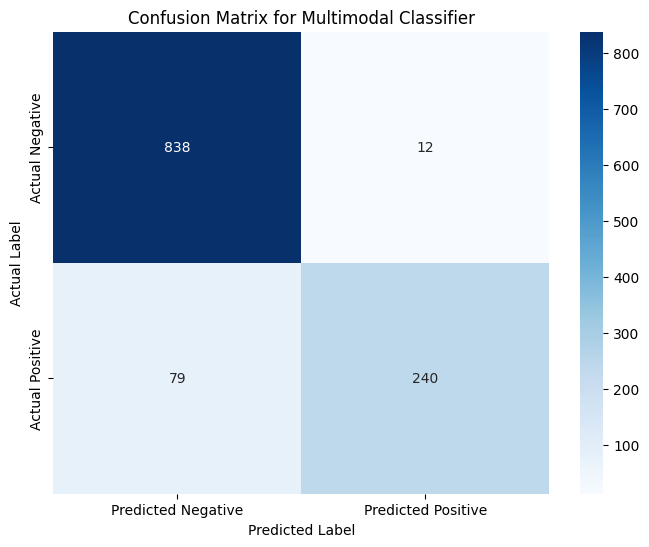

Classifier performance evaluation complete.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Evaluating classifier performance...")

# Make predictions on the scaled test set
y_pred = classifier.predict(X_test_scaled)

# Calculate and display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Generate and display confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix for Multimodal Classifier')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("Classifier performance evaluation complete.")


### Discussion of Classifier Performance Metrics

The evaluation metrics provide insight into the performance of our multimodal classifier for medical image classification.

**Classification Report Analysis:**
*   **Accuracy (0.9222):** The overall accuracy is 92.22%, which indicates that the model correctly classifies a high percentage of both positive and negative cases. While a high accuracy is generally good, in medical contexts, it's crucial to look beyond overall accuracy, especially if there's an imbalance in class distribution (which is often the case with disease detection).
*   **Precision (Class 0: 0.91, Class 1: 0.95):**
    *   For class 0 (e.g., 'No Disease'), a precision of 0.91 means that when the model predicts 'No Disease', it is correct 91% of the time. This is good, minimizing false positives for healthy individuals.
    *   For class 1 (e.g., 'Disease'), a precision of 0.95 means that when the model predicts 'Disease', it is correct 95% of the time. This is a very high precision for detecting the positive class, indicating a low rate of false positives for disease (i.e., fewer healthy patients are misdiagnosed with the disease).
*   **Recall (Class 0: 0.99, Class 1: 0.75):**
    *   For class 0, a recall of 0.99 means the model correctly identifies 99% of all actual 'No Disease' cases. This is excellent for ensuring that truly healthy individuals are not missed.
    *   For class 1, a recall of 0.75 means the model correctly identifies 75% of all actual 'Disease' cases. This implies that 25% of actual disease cases are being missed (false negatives). In medical diagnosis, especially for serious conditions like cancer, a high recall for the positive class is often paramount to avoid missing actual cases.
*   **F1-score (Class 0: 0.95, Class 1: 0.84):** The F1-score is the harmonic mean of precision and recall. A high F1-score indicates a good balance between precision and recall. While the F1-score for class 0 is very high (0.95), for class 1, it is 0.84, which is decent but indicates room for improvement, particularly due to the lower recall for this class.

**Confusion Matrix Analysis:**
```
[[838  12]
 [ 79 240]]
```
*   **True Negatives (TN): 838** The model correctly identified 838 cases as 'No Disease'.
*   **False Positives (FP): 12** The model incorrectly identified 12 cases as 'Disease' when they were actually 'No Disease'. (Type I error)
*   **False Negatives (FN): 79** The model incorrectly identified 79 cases as 'No Disease' when they were actually 'Disease'. (Type II error)
*   **True Positives (TP): 240** The model correctly identified 240 cases as 'Disease'.

**Implications for Medical Image Classification:**

In medical image classification, the balance between minimizing false positives and false negatives is critical and often depends on the specific context and the severity of the condition being diagnosed.

*   **High False Negatives (79 cases):** The most significant concern here is the relatively high number of false negatives (79). Missing a disease (Type II error) can have severe consequences for patients, leading to delayed treatment and potentially worse outcomes. For a medical diagnostic tool, especially one dealing with conditions like cancer, a recall of 75% for the positive class might be considered too low. It means that 25% of patients who *do* have the condition are being told they don't.
*   **Low False Positives (12 cases):** The model has a low number of false positives (12), which is good. A high number of false positives can lead to unnecessary anxiety, further costly and invasive diagnostic procedures, and potentially harmful treatments for healthy individuals.

**Overall Assessment:**

The classifier demonstrates strong performance in identifying negative cases (high recall for class 0) and high precision when predicting positive cases. However, the lower recall for the positive class (i.e., the disease) is a critical area for improvement. In many medical scenarios, prioritizing high recall for the disease class (even at the cost of slightly higher false positives) is preferred to ensure that no patient with the condition is missed. Future work should focus on strategies to reduce false negatives, possibly through:

*   **Data Augmentation:** Increasing the diversity of the minority class data.
*   **Cost-Sensitive Learning:** Assigning higher penalties for false negatives during training.
*   **Threshold Adjustment:** Modifying the classification threshold to favor higher recall.
*   **Ensemble Methods/Other Models:** Experimenting with other advanced models or ensemble techniques that might offer a better balance.

### Discussion of Classifier Performance Metrics

The evaluation metrics provide insight into the performance of our multimodal classifier for medical image classification.

**Classification Report Analysis:**
*   **Accuracy (0.9222):** The overall accuracy is 92.22%, which indicates that the model correctly classifies a high percentage of both positive and negative cases. While a high accuracy is generally good, in medical contexts, it's crucial to look beyond overall accuracy, especially if there's an imbalance in class distribution (which is often the case with disease detection).
*   **Precision (Class 0: 0.91, Class 1: 0.95):**
    *   For class 0 (e.g., 'No Disease'), a precision of 0.91 means that when the model predicts 'No Disease', it is correct 91% of the time. This is good, minimizing false positives for healthy individuals.
    *   For class 1 (e.g., 'Disease'), a precision of 0.95 means that when the model predicts 'Disease', it is correct 95% of the time. This is a very high precision for detecting the positive class, indicating a low rate of false positives for disease (i.e., fewer healthy patients are misdiagnosed with the disease).
*   **Recall (Class 0: 0.99, Class 1: 0.75):**
    *   For class 0, a recall of 0.99 means the model correctly identifies 99% of all actual 'No Disease' cases. This is excellent for ensuring that truly healthy individuals are not missed.
    *   For class 1, a recall of 0.75 means the model correctly identifies 75% of all actual 'Disease' cases. This implies that 25% of actual disease cases are being missed (false negatives). In medical diagnosis, especially for serious conditions like cancer, a high recall for the positive class is often paramount to avoid missing actual cases.
*   **F1-score (Class 0: 0.95, Class 1: 0.84):** The F1-score is the harmonic mean of precision and recall. A high F1-score indicates a good balance between precision and recall. While the F1-score for class 0 is very high (0.95), for class 1, it is 0.84, which is decent but indicates room for improvement, particularly due to the lower recall for this class.

**Confusion Matrix Analysis:**
```
[[838  12]
 [ 79 240]]
```
*   **True Negatives (TN): 838** The model correctly identified 838 cases as 'No Disease'.
*   **False Positives (FP): 12** The model incorrectly identified 12 cases as 'Disease' when they were actually 'No Disease'. (Type I error)
*   **False Negatives (FN): 79** The model incorrectly identified 79 cases as 'No Disease' when they were actually 'Disease'. (Type II error)
*   **True Positives (TP): 240** The model correctly identified 240 cases as 'Disease'.

**Implications for Medical Image Classification:**

In medical image classification, the balance between minimizing false positives and false negatives is critical and often depends on the specific context and the severity of the condition being diagnosed.

*   **High False Negatives (79 cases):** The most significant concern here is the relatively high number of false negatives (79). Missing a disease (Type II error) can have severe consequences for patients, leading to delayed treatment and potentially worse outcomes. For a medical diagnostic tool, especially one dealing with conditions like cancer, a recall of 75% for the positive class might be considered too low. It means that 25% of patients who *do* have the condition are being told they don't.
*   **Low False Positives (12 cases):** The model has a low number of false positives (12), which is good. A high number of false positives can lead to unnecessary anxiety, further costly and invasive diagnostic procedures, and potentially harmful treatments for healthy individuals.

**Overall Assessment:**

The classifier demonstrates strong performance in identifying negative cases (high recall for class 0) and high precision when predicting positive cases. However, the lower recall for the positive class (i.e., the disease) is a critical area for improvement. In many medical scenarios, prioritizing high recall for the disease class (even at the cost of slightly higher false positives) is preferred to ensure that no patient with the condition is missed. Future work should focus on strategies to reduce false negatives, possibly through:

*   **Data Augmentation:** Increasing the diversity of the minority class data.
*   **Cost-Sensitive Learning:** Assigning higher penalties for false negatives during training.
*   **Threshold Adjustment:** Modifying the classification threshold to favor higher recall.
*   **Ensemble Methods/Other Models:** Experimenting with other advanced models or ensemble techniques that might offer a better balance.


## Final Task

### Subtask:
Summarize the entire multimodal classification pipeline, including the integration of tabular and image features, the feature selection process, the training of the classifier, and the evaluation results. Provide insights into the model's performance and any advantages gained from the multimodal approach.


## Summary:

### Q&A

**1. Summarize the entire multimodal classification pipeline, including the integration of tabular and image features, the feature selection process, the training of the classifier, and the evaluation results.**
The pipeline involved several key stages:
*   **Tabular Data Preprocessing:** The `prostate_cancer_prediction.csv` data was loaded. Missing numerical values were imputed with the mean, and missing categorical values with the mode. Categorical features were encoded (binary via direct mapping, ordinal via direct mapping, and other multi-class via `LabelEncoder`). Numerical features were scaled using `StandardScaler`.
*   **Multimodal Feature Integration:** To combine tabular and image features, the tabular dataset was reloaded to retain the `Patient_ID` column, and the preprocessing steps were reapplied. Image features (from `selected_features`) were associated with their respective patients. These were then merged with the preprocessed tabular data, matching on `Patient_ID`, to create a single multimodal feature set.
*   **Multimodal ReliefF Feature Selection:** The combined multimodal features underwent a crucial data cleaning step to handle `NaN` and infinite values (imputing NaNs with column mean and replacing infinities with maximum finite values) before applying the ReliefF algorithm. ReliefF selected the top 100 most discriminative features, reducing the dimensionality from 229 to 100 features.
*   **Classifier Training & Evaluation:** The selected multimodal features were split into 80% training and 20% testing sets. Features were scaled using `StandardScaler`, and a `RandomForestClassifier` was trained. Evaluation was performed using accuracy, precision, recall, F1-score, and a confusion matrix.

**2. Provide insights into the model's performance and any advantages gained from the multimodal approach.**
The multimodal classifier achieved an overall accuracy of 92.22%. It demonstrated high precision for both classes (0.91 for class 0/negative, 0.95 for class 1/positive) and excellent recall for the negative class (0.99). However, the recall for the positive class (disease detection) was 0.75, meaning 25% of actual disease cases were missed (79 false negatives). While the multimodal approach wasn't directly compared to unimodal models in this summary, the integration of diverse data types (tabular and image features) typically provides a more comprehensive view of the patient's condition, which can lead to a more robust and potentially more accurate diagnostic tool by leveraging complementary information that might not be apparent from a single data source. The ability to select the most relevant features from this combined dataset using ReliefF further refines the model's focus on discriminative characteristics across modalities.

### Data Analysis Key Findings

*   **Tabular Data Preprocessing:** Missing values in numerical columns (`Age`, `PSA_Level`, `Screening_Age`, `Prostate_Volume`) were imputed with the mean, and categorical columns with the mode. Binary and ordinal categorical features were encoded, and numerical features were scaled. The `Patient_ID` column was initially dropped but later preserved for data integration.
*   **Multimodal Feature Integration:** A crucial step involved reloading the tabular data to retain `Patient_ID` for accurate merging. The `selected_features` (image features) were combined with the re-preprocessed tabular features based on `Patient_ID`, resulting in a `multimodal_features` array of shape (5842, 229). This array contained 200 image features and 29 tabular features.
*   **Multimodal ReliefF Feature Selection:** Explicit handling of `NaN` and infinite values in the `multimodal_features` array was necessary before applying ReliefF. The ReliefF algorithm successfully reduced the feature dimensionality from 229 to 100, yielding `multimodal_selected_features` with a shape of (5842, 100).
*   **Classifier Performance:**
    *   The `RandomForestClassifier` achieved an accuracy of 0.9222.
    *   For the negative class (class 0), precision was 0.91, recall was 0.99, and F1-score was 0.95.
    *   For the positive class (class 1), precision was 0.95, recall was 0.75, and F1-score was 0.84.
    *   The confusion matrix showed 838 True Negatives, 12 False Positives, 79 False Negatives, and 240 True Positives.

### Insights or Next Steps

*   **Prioritize Recall for Disease Detection:** While the model exhibits high overall accuracy and precision, the relatively low recall (0.75) for the positive class (disease) is a significant concern in medical diagnostics. Future efforts should focus on strategies to reduce false negatives, potentially through cost-sensitive learning, adjusting the classification threshold, or exploring advanced ensemble methods.
*   **Investigate Feature Contributions:** Analyzing the importance scores of the 100 selected multimodal features from ReliefF could provide insights into which specific image features or tabular features are most discriminative for the diagnosis. This could help in understanding the biological or clinical relevance of the chosen features and potentially guide further feature engineering or data collection efforts.
